# OpenCellID Data Exploration with Pandas (accelerated by cudf.pandas) <a target="_blank" href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_opencellid_demo.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

[OpenCellID](https://wiki.opencellid.org/wiki/What_is_OpenCellID) is the world's largest collaborative community project that collects GPS positions of cell towers, used free of charge, for a multitude of commercial and private purposes.

The OpenCellID project was primarily created to serve as a data source for GSM localisation. As of October, 2017, the database contained almost 36 million unique GSM Cell IDs. More than 75,000 contributors have already registered with OpenCellID, contributing millions of new measurements every day in average to the OpenCellID database.

OpenCellID provides 100% free Cell ID data under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/). The OpenCellID database is published under an open content license with the intention of promoting free use and redistribution of the data. All data uploaded by any of the contributors can also be downloaded again free of charge - no exceptions!

## Load cudf.pandas extension

In [ ]:
%load_ext cudf.pandas

## Import required Packages

In [ ]:
# Install required packages
! pip install -q hvplot pydeck panel jupyter_bokeh holoviews==1.18.3

In [ ]:
# importing viz libraries
import hvplot.pandas
import pydeck as pdk
import panel as pn
import param
import time
pn.extension("deckgl", loading_indicator=True, template='material')

#importing pandas
import pandas as pd

## Download cell-data (https://www.opencellid.org/)

### Dataset Options
1. [Worldwide Dataset](https://data.rapids.ai/cudf/datasets/cell_towers.tar.xz) 
2. [US Dataset](https://data.rapids.ai/cudf/datasets/cell_towers_us.tar.xz): Suitable for the free tier of Google Colab.
### Usage in Google Colab
- For a smaller dataset to test the notebook with the free tier of Google Colab, use: download_and_extract('us').
### Additional Information
- Users can register for an account on OpenCellID to obtain a data access token and download the latest dataset directly.
- The auto-downloader provided in this notebook will not fetch the latest dataset from OpenCellID. For the latest data, manual download with an access token is required.
- If the latest data is not a priority, the included dataset dated May 2024 will suffice for exploring the notebook's functionalities.


In [ ]:
import os
import subprocess

file_name = "opencellid_downloader.py"
file_url = f"https://raw.githubusercontent.com/rapidsai-community/showcase/main/getting_started_tutorials/{file_name}"

if os.path.exists(file_name):
    print(f"The file '{file_name}' exists in the current directory.")
else:
    print(f"The file '{file_name}' does not exist in the current directory. Downloading it now...")
    try:
        subprocess.run(["wget", file_url], check=True)
        print(f"Successfully downloaded '{file_name}'.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download the file. Error: {e}")
    except FileNotFoundError:
        print("The 'wget' command is not found. Please ensure it's installed and in your system PATH.")

In [ ]:
from opencellid_downloader import download_and_extract
download_and_extract('us') # use download_and_extract('worldwide') to download the entire world dataset

## Read cell-data (https://www.opencellid.org/)

### Column Descriptions

- **Radio**:	The generation of broadband cellular network technology (Eg. LTE, GSM)

- **MCC**:	Mobile country code. This info is publicly shared by International Telecommunication Union (link)

- **MNC**:	Mobile network code. This info is publicly shared by International Telecommunication Union (link)

- **AREA**:	Location Area Code

- **CELL**:	This is a unique number used to identify each Base transceiver station or sector of BTS

- **Longitude**:	Longitude, is a geographic coordinate that specifies the east-west position of a point on the Earth's surface

- **Latitude**:	Latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.

- **Range**:	Approximate area within which the cell could be. (In meters)

- **Samples**:	Number of measures processed to get a particular data point

- **Changeable=1**:	The location is determined by processing samples

- **Changeable=0**:	The location is directly obtained from the telecom firm

- **Created**:	When a particular cell was first added to database (UNIX timestamp)

- **Updated**:	When a particular cell was last seen (UNIX timestamp)

- **AverageSignal**:	To get the positions of cells, OpenCelliD processes measurements from data contributors. Each measurement includes GPS location of device + Scanned cell identifier (MCC-MNC-LAC-CID) + Other device properties (Signal strength). In this process, signal strength of the device is averaged. Most ‘averageSignal’ values are 0 because OpenCelliD simply didn’t receive signal strength values.


In [ ]:
%%time
df = pd.read_csv('./opencellid_data/cell_towers_us.csv') # ./opencellid_data/cell_towers.csv if using the worldwide dataset

df.rename(columns={'net':'MNC', 'mcc':'MCC'}, inplace=True)

print(df.shape)

In [ ]:
df.head()

## Read mcc-mnc dataset to map to carrier name

Publicaly available dataset: https://mcc-mnc.net/ powered by [simbase](https://www.simbase.com/)


In [ ]:
%%time
df_carriers = pd.read_csv('https://s3.amazonaws.com/mcc-mnc.net/mcc-mnc.csv', sep=';')[['MCC', 'MNC', 'Country', 'Operator']]

# rename Operator to Operator
df_carriers.rename(columns={'Operator': 'Operator'}, inplace=True)

In [ ]:
df_carriers.head()

In [ ]:
%%time
df_final = df.merge(df_carriers, left_on=['MCC', 'MNC'], right_on=['MCC', 'MNC']).drop(columns=['MCC', 'MNC'])

In [ ]:
%%time
df_final.head()

### Analyzing Operator types

In [ ]:
%%time
# Most reported cell towers by operators
df_final.Operator.value_counts()

In [ ]:
%%time
# Categorizing Operators with less than 1000 cells to other to reduce clutter
operators_to_rename = df_final.Operator.value_counts()[df_final.Operator.value_counts()<=1000].index.tolist()
len(operators_to_rename)

In [ ]:
%%time
df_final['Operator'] = df_final['Operator'].replace(operators_to_rename, 'Other')

In [ ]:
operators_df = df_final.groupby(['Country', 'Operator']).agg({'radio':'count'}).reset_index()

In [ ]:
# Final operator analysis
operators_df

### Analyzing Radio types

In [ ]:
# Analyzing radio cell tower types
pn.pane.HoloViews(
    df_final.radio.value_counts().reset_index().hvplot.barh(x='radio')
)

In [ ]:
# Most LTE towers country wise
pn.pane.HoloViews(
    df_final[df_final.radio == 'LTE'].Country.value_counts().reset_index().head(10).hvplot.barh(x='Country')
)

In [ ]:
%%time
columns = ['radio', 'area', 'lon', 'lat', 'range', 'samples', 'changeable', 'created', 'averageSignal', 'Country', 'Operator']
df_final = df_final[columns]

## Create an exploratory panel dashboard

In [ ]:
%%time
# Convert 'radio' to a color value to display in the dashboard
color_map = {
    'UMTS': [255, 165, 0, 140],  # Orange
    'LTE': [255, 0, 0, 140],     # Red
    'GSM': [135, 206, 250, 140], # Light Blue
    'CDMA': [123, 104, 238, 140],# Medium Slate Blue
    'NR': [0, 128, 0, 140]       # Green
}
df_final['color'] = df_final['radio'].map(color_map)
df_final['created'] = pd.to_datetime(df['created'], unit='s').dt.year

In [ ]:
# declare a legend
legend_markdown = """
### Radio Type Legend

- **UMTS**: <span style="height: 10px; width: 10px; background-color: rgba(255, 165, 0, 0.55); border-radius: 50%; display: inline-block;"></span>
- **LTE**: <span style="height: 10px; width: 10px; background-color: rgba(255, 0, 0, 0.55); border-radius: 50%; display: inline-block;"></span>
- **GSM**: <span style="height: 10px; width: 10px; background-color: rgba(135, 206, 250, 0.55); border-radius: 50%; display: inline-block;"></span>
- **CDMA**: <span style="height: 10px; width: 10px; background-color: rgba(123, 104, 238, 0.55); border-radius: 50%; display: inline-block;"></span>
- **NR**: <span style="height: 10px; width: 10px; background-color: rgba(0, 128, 0, 0.55); border-radius: 50%; display: inline-block;"></span>
"""

In [ ]:
class CellTowerDashboard(param.Parameterized):
    # filter by radio cell tower type (GSM, LTE, UMTS, CDMA or all)
    radio_type = param.ListSelector(objects=df_final['radio'].unique().tolist(), default=[])
    # filter by radio operator type (TMobile, At&t, ...)
    operator = param.ListSelector(objects=df_final.Operator.value_counts().sort_values(ascending=False).index.tolist(), default=[])
    # country to display the cell-tower data points for
    country = param.ListSelector(objects=df_final.Country.value_counts().sort_values(ascending=False).index.tolist(), default=[])
    # Filter by date the tower was first reported
    date_range = param.Range(bounds=(df_final['created'].min(), df_final['created'].max()), step=1, default=(df_final['created'].min(), df_final['created'].max()))
        
    # Since rendering is equal for both pandas and cudf.pandas, we track the compute progress where cudf.pandas is much more efficient
    compute_progress = param.Integer(default=0, bounds=(0, 100))
    
    # point_budget is used to curtail number of points rendered at any time. Can be adjusted as per client browser capabilities
    point_budget = param.Integer(default=50_000, bounds=(10000,100_000), step=10_000)
    
    selected_data_size = param.Integer(default=df_final.shape[0])
    df = param.DataFrame(default=df_final.sample(50_000))
    execution_time = param.Number(default=0, doc="Execution Time")

    @param.depends('radio_type', 'operator', 'date_range', 'country', 'point_budget', watch=True)
    def filter_dataframe(self):
        start_time = time.time()  # Start time
        self.compute_progress = 0
        filtered_indices = df_final['created'].between(self.date_range[0], self.date_range[1])
        self.compute_progress = 25
        if self.radio_type:
            filtered_indices &= df_final['radio'].isin(self.radio_type)
        self.compute_progress = 50
        if self.operator:
            filtered_indices &= df_final['Operator'].isin(self.operator)
        self.compute_progress = 75
        if self.country:
            filtered_indices &= df_final['Country'].isin(self.country)
        self.compute_progress = 100

        filtered_df = df_final[filtered_indices]

        self.selected_data_size = filtered_df.shape[0]
        if filtered_df.shape[0] > self.point_budget:
            filtered_df = filtered_df.sample(n=self.point_budget)
        
        end_time = time.time()  # End time
        self.execution_time = end_time - start_time  # Compute execution time

        self.df = filtered_df        

    
    @param.depends('df')
    def update_scatter_plot(self):
        COUNTRIES = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_scale_rank.geojson"
        # Define the layer
        layers = [
            pdk.Layer(
                "GeoJsonLayer",
                id="base-map",
                data=COUNTRIES,
                stroked=False,
                filled=True,
                get_fill_color=[200, 200, 200],
            ),
            pdk.Layer(
            'ScatterplotLayer',  # Use ScatterplotLayer
            self.df,
            pickable=True,
            opacity=0.8,
            stroked=True,
            filled=True,
            radius_scale=6,
            radius_min_pixels=1,
            radius_max_pixels=10,
            line_width_min_pixels=1,
            get_position=['lon', 'lat'],
            radius=1000,
            get_line_color="color"
        )]
        # Set the viewport location
        view_state = pdk.ViewState(latitude=self.df.lat.median(), longitude=self.df.lon.median(), zoom=0, bearing=0, pitch=0)
        view = pdk.View(type="_GlobeView", controller=True)
        # Render
        return pn.Column("### Visualized Data Points", self.visualizedDataSize,
                pn.pane.DeckGL(pdk.Deck(views=[view], layers=layers, initial_view_state=view_state, map_provider=None)))

    @param.depends('selected_data_size')
    def computedDataSize(self):
        return pn.widgets.Number(value=self.selected_data_size, format="{value:,}", font_size='25pt')


    @param.depends('execution_time')
    def executionTime(self):
        return pn.pane.Markdown(f"### Compute Time: {self.execution_time:.2f} seconds")

    @param.depends('point_budget', 'selected_data_size')
    def visualizedDataSize(self):
        visualized_points = min(self.selected_data_size, self.point_budget)
        return pn.widgets.Number(value=visualized_points, format="{value:,}", font_size='15pt')
    
    @param.depends('df')
    def update_bar_charts(self): 
        radio_count = self.df['radio'].value_counts().head().hvplot.barh(title='Radio Type Count', responsive=True, tools=['hover']).opts(default_tools=[])
        operator_count = self.df['Operator'].value_counts().head().hvplot.barh(title='Operator Tower Count', responsive=True, tools=['hover']).opts(default_tools=[])
        return pn.Column(radio_count, operator_count)

    @param.depends('compute_progress', 'execution_time')
    def compute_bar(self):
        return pn.widgets.Progress(value=self.compute_progress,active=False, sizing_mode='stretch_width')

    @param.depends('df')
    def view(self):
        box = pn.GridSpec(ncols=5, width=1400, height=600)
        widgets = pn.Column(
            pn.WidgetBox(
                "### Queried Data Points",
                self.computedDataSize,
                pn.Column(
                    pn.Row(
                        self.executionTime,
                        pn.widgets.TooltipIcon(value="While the rendering process remains consistent between pandas and cudf, our focus is on the significant reduction in compute time achieved with cudf.pandas"),
                    ),
                    self.compute_bar),
                sizing_mode="stretch_width"
            ),
            pn.WidgetBox("### Query Filters",
                pn.Param(self.param.radio_type, widgets={'radio_type': {"type": pn.widgets.MultiChoice, "sizing_mode": "stretch_width"}}),
                pn.Param(self.param.operator, widgets={'operator': {"type": pn.widgets.MultiChoice, "sizing_mode": "stretch_width"}}),
                pn.Param(self.param.country, widgets={'country': {"type": pn.widgets.MultiChoice, "sizing_mode": "stretch_width"}}),
                pn.Param(self.param.date_range, widgets={'date_range': {"type": pn.widgets.RangeSlider, "throttled": True, "sizing_mode": "stretch_width"}}),
                pn.Param(self.param.point_budget, widgets={'point_budget': {"type": pn.widgets.IntSlider, "throttled": True, "sizing_mode": "stretch_width"}}),
                sizing_mode="stretch_width"
            )
        )

        box[:,0] = widgets        
        box[:,1:3] = self.update_scatter_plot
        box[:,3:5] = self.update_bar_charts
        return box

In [ ]:
dashboard = CellTowerDashboard(point_budget=10_000)
dashboard.view()

Dashboard Screenshot:

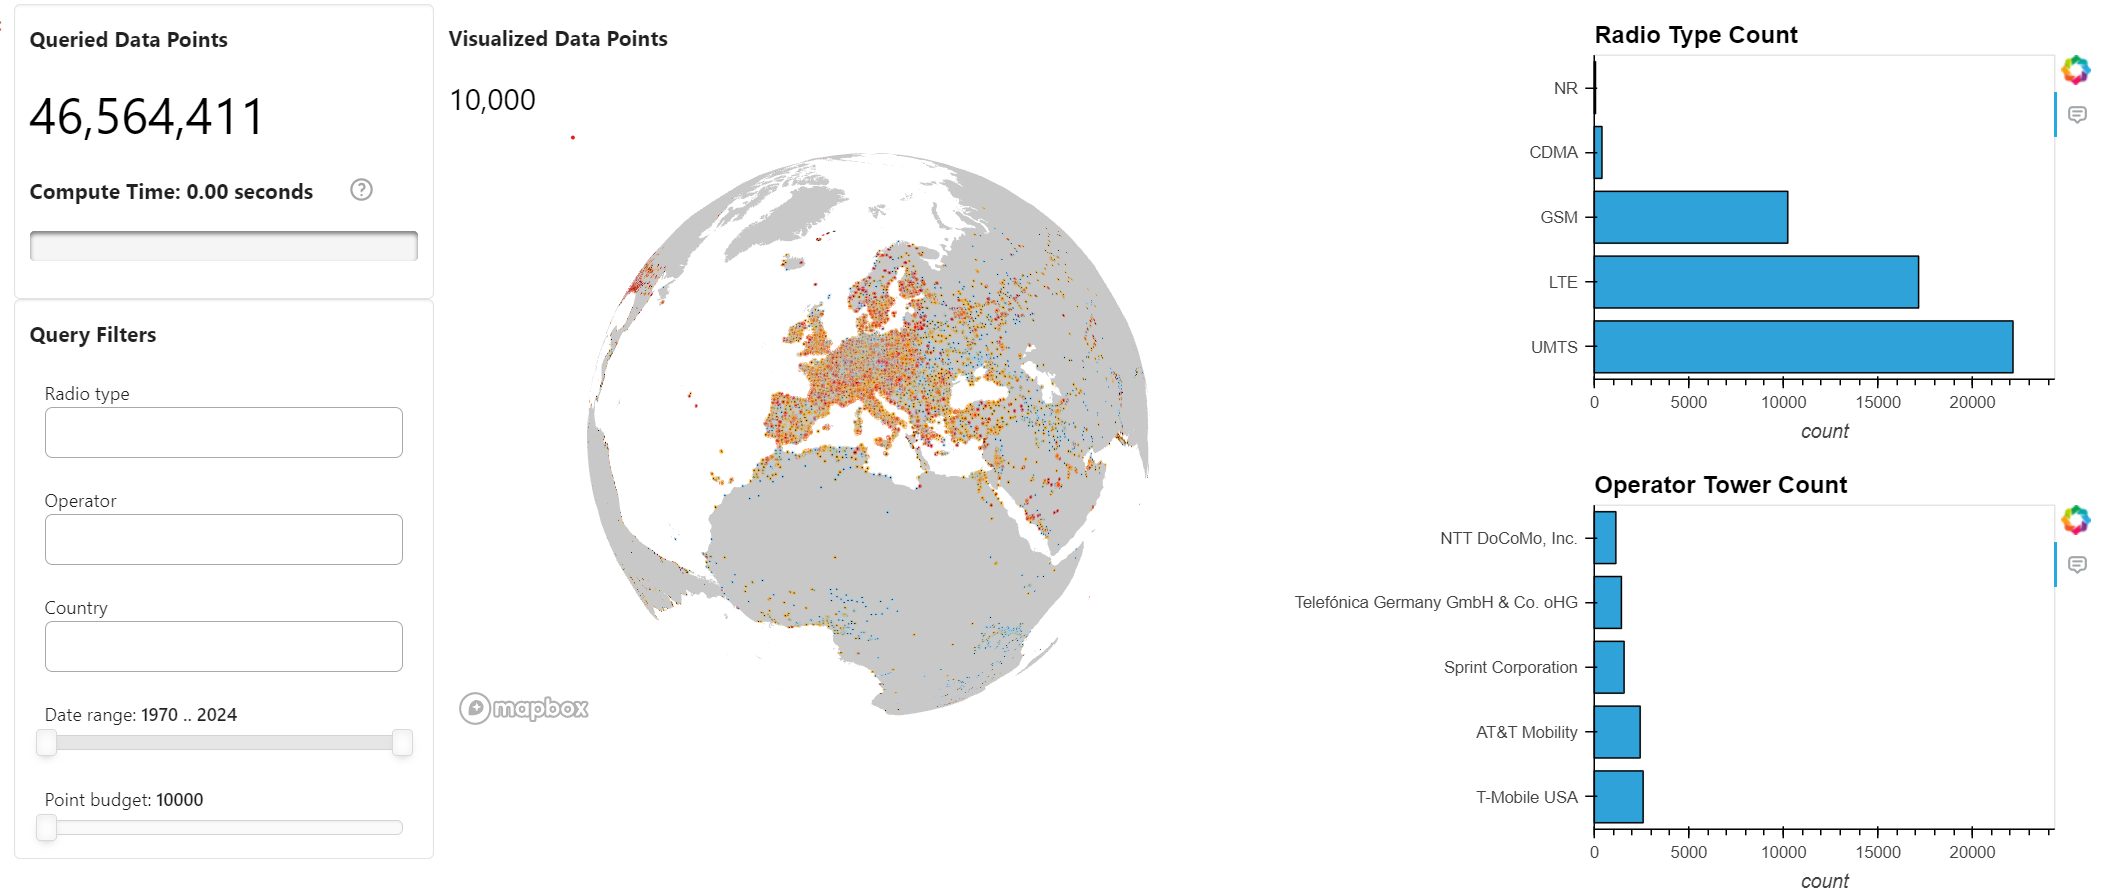